In [5]:
from pathlib import Path
import os

In [6]:
#NOTE: DONT USE RELATIVE PATHS FOR THE MODELS PROVIDED BY L5
experiments_directory = Path(Path(os.path.abspath('')).parent.parent, "Experiments")
experiments_directory.mkdir(parents=True, exist_ok=True)

data_directory = Path(experiments_directory, "data")
data_directory.mkdir(parents=True, exist_ok=True)

prediction_directory = Path(experiments_directory, "prediction")
prediction_directory.mkdir(parents=True, exist_ok=True)

prediction_evaluation_directory = Path(prediction_directory, "evaluation")
prediction_evaluation_directory.mkdir(parents=True, exist_ok=True)

save_directory = Path(prediction_evaluation_directory, "saved_outputs")
save_directory.mkdir(parents=True, exist_ok=True)

In [7]:
import os
os.chdir(prediction_evaluation_directory)

In [8]:
%%writefile requirements.txt
l5kit
pyyaml
wandb
ray==2.0.0rc1
"ray[air]"

Overwriting requirements.txt


In [23]:
%%capture
# !pip install -r requirements.txt
!pip install l5kit pyyaml wandb
!pip install ray==2.0.0rc1
!pip install "ray[air]"

In [10]:
import wandb
wandb.login()

wandb: Currently logged in as: a-sh0ts. Use `wandb login --relogin` to force relogin


True

In [24]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

# Pull data

In [12]:
api = wandb.Api()

In [35]:
# Run information
wandb_entity = "l5-demo"
project_name = "l5-prediction"
run_name = "evaluate-latest-models"
run_type = "evaluate"
run_description = """
Evaluate a prediction Av model and report results
"""
tags = ["evaluate", "prediction"]

In [14]:
#Grab all run trials from a specific date range?
#TODO: figure out best criteria to get runs
runs = api.runs(f'{wandb_entity}/{project_name}-trials', {
    # "$and": [{
    # 'created_at': {
    #     "$lt": 'YYYY-MM-DDT##',
    #     "$gt": 'YYYY-MM-DDT##'
    #     }
    # }]
})

In [15]:
len(runs)

10

In [16]:
#TODO: Better promotion flow

In [17]:
run_model_map = {}
for run in runs:
    for art in run.logged_artifacts():
        if "latest" in art.aliases:
            run_model_map[run.name] = {
                "loss": run.summary["loss"],
                "avg_loss": run.summary["avg_loss"],
                "art": art,
            }

In [19]:
#NOTE: this assumes minimizing the value
metric_of_interest = "avg_loss"
best_metric_value = float("inf")
best_art = None
for run_name, art_details in run_model_map.items():
    current_metric_value = art_details[metric_of_interest]
    if current_metric_value < best_metric_value:
        best_metric_value = current_metric_value
        best_art = art_details["art"]

In [26]:
best_model_dir = best_art.download("best_model")

wandb: Downloading large artifact checkpoint_TorchTrainer_06d0f300:v6, 90.80MB. 3 files... Done. 0:0:0.1


In [28]:
from ray.air.checkpoint import Checkpoint

In [29]:
checkpoint = Checkpoint.from_directory(best_model_dir)

In [30]:
recovered_model = checkpoint.to_dict()

In [33]:
model = recovered_model['model']

In [36]:
run = wandb.init(
    entity=wandb_entity,
    project=project_name,
    job_type=run_type,
    name=run_name,
    notes=run_description,
    tags=tags
)

wandb: Currently logged in as: a-sh0ts (l5-demo). Use `wandb login --relogin` to force relogin


In [37]:
artifact_entity = "l5-demo"
artifact_project = "l5-common"
artifact_name = "l5-data"
artifact_alias = "latest"
artifact_type = "dataset"

In [38]:
artifact = run.use_artifact(f"{artifact_entity}/{artifact_project}/{artifact_name}:{artifact_alias}", type=artifact_type)

In [39]:
_ = artifact.download(data_directory)

wandb: Downloading large artifact l5-data:latest, 2386.92MB. 517 files... Done. 0:0:0.2


In [40]:
#BUG: need to seperate runs into download and training due to issues with routing runs after ray.tune
# run.finish()

In [41]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get config
cfg = load_config_data(Path(data_directory, "configurations", "agent_motion_config.yaml"))
l5_data_location = Path(data_directory, "dataset")
# run.config.update(cfg)

In [42]:
# cfg["zarr_dataset_location"] = l5_data_location
os.environ["L5KIT_DATA_FOLDER"] = str(l5_data_location)

In [44]:
dm = LocalDataManager()

In [48]:
rasterizer = build_rasterizer(cfg, dm)

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

In [49]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

extracting GT: 100%|██████████| 480/480 [00:07<00:00, 64.47it/s]


The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [50]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


def forward(data, model, criterion):
    inputs = data["image"]
    target_availabilities = data["target_availabilities"].unsqueeze(-1)
    targets = data["target_positions"]
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [55]:
#TODO: serialize the forward in the artifact? Is there a way to better do this with ray?

In [56]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

In [58]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)
#TODO: see if there is a better ray way
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss(reduction="none")

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = transform_points(agents_coords, world_from_agents) - centroids[:, None, :2]
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [59]:
pred_path = Path(save_directory, "preds.csv")

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [60]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 1305242.9341740778
time_displace [ 13.96687033  10.88338713  29.50641653  47.92536779  55.24854031
  52.44754215  31.81677206  39.82151814  46.65652074  55.28941292
  66.70421496  70.6844966   86.37954206  87.52249304  91.84836182
  95.8761609  100.43152848  97.17309371 101.69614227  93.23565882
 105.02683404 106.74094409 109.21823315 118.98909443 122.12125079
 135.52674223 141.4130986  159.76502746 170.07380514 175.46994818
 190.45191295 202.94495393 204.11543822 226.92310901 243.46699239
 248.2712255  261.99137683 268.20729362 285.82465437 291.15859817
 296.29478685 306.07717532 315.38903278 316.84684662 320.32717051
 339.94314756 342.74287939 350.43930949 358.60003947 356.25704039]


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


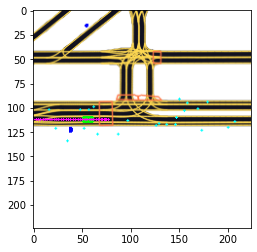

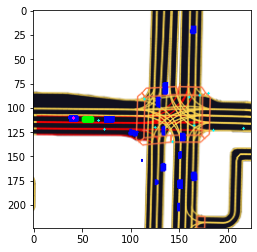

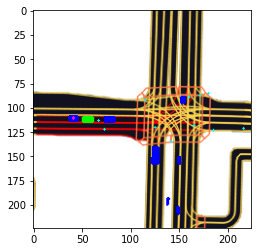

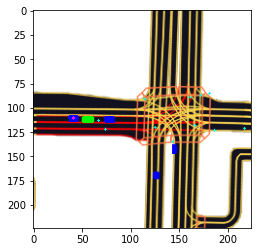

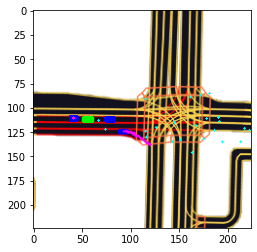

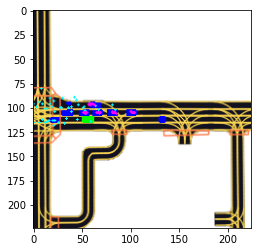

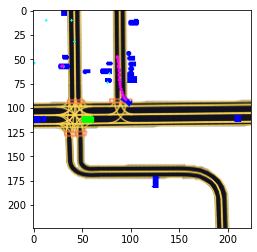

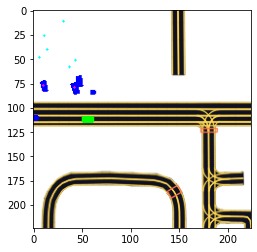

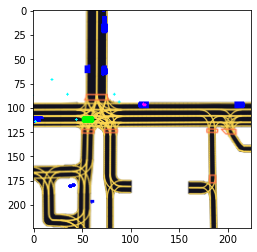

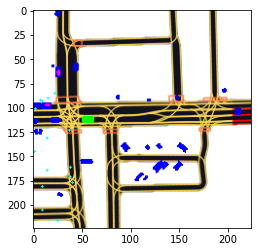

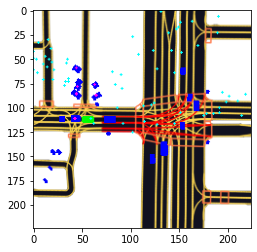

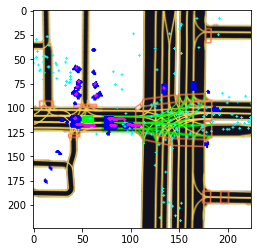

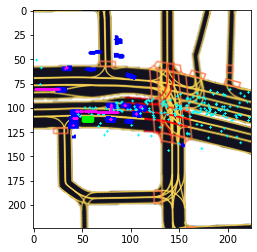

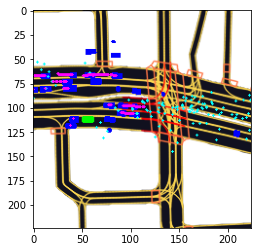

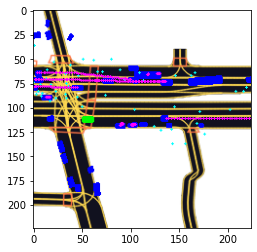

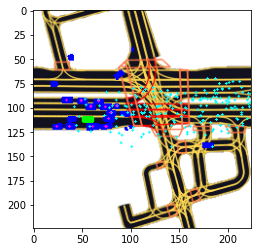

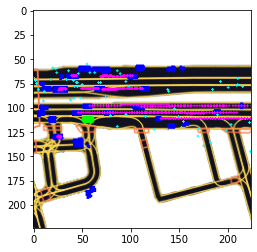

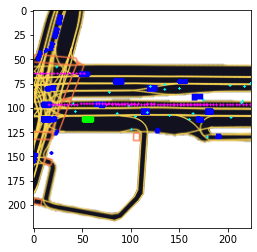

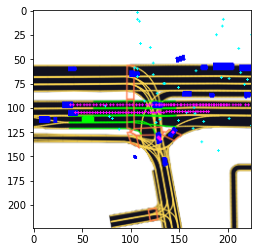

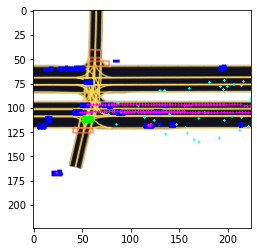

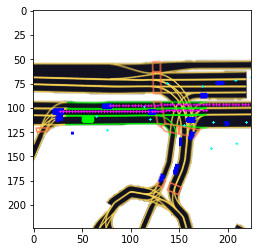

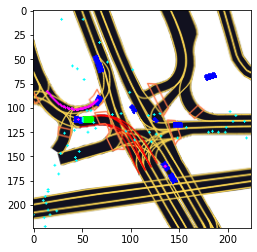

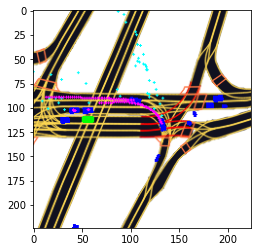

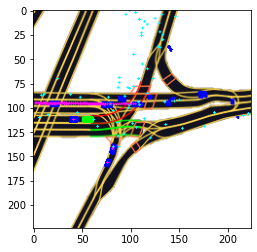

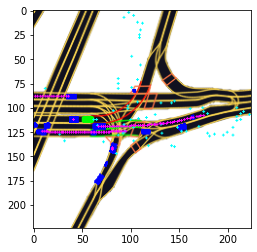

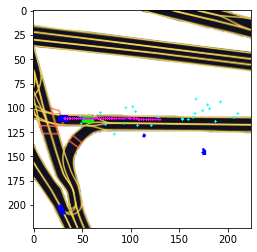

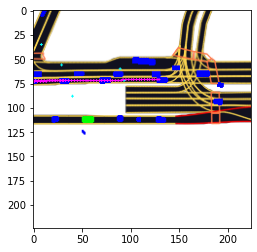

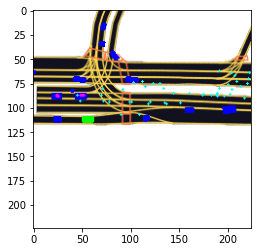

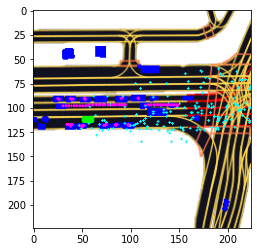

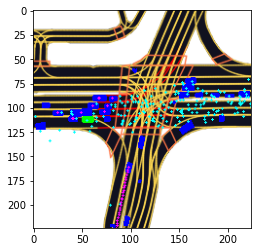

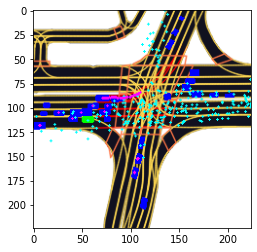

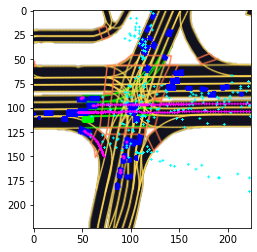

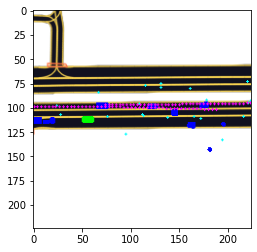

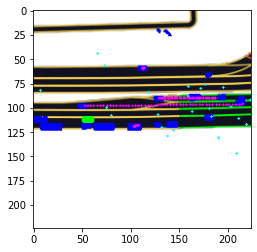

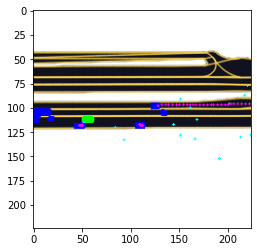

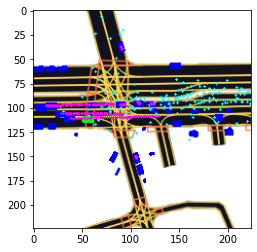

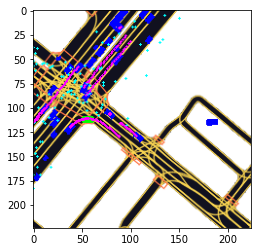

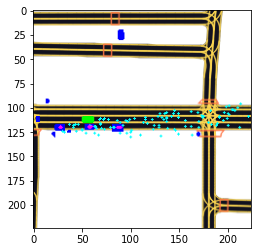

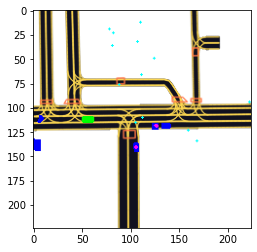

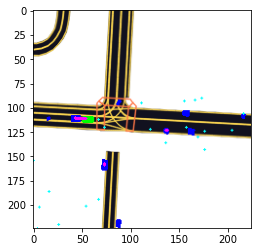

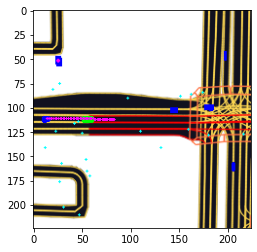

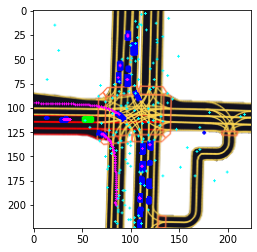

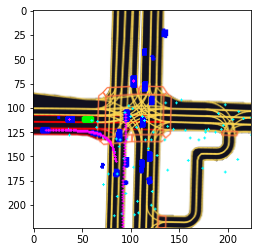

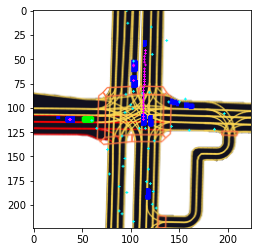

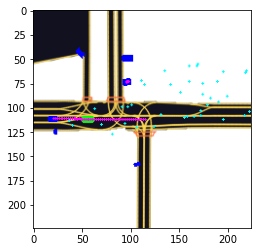

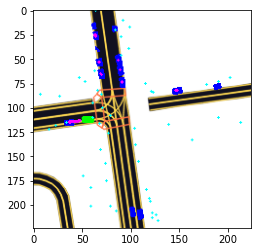

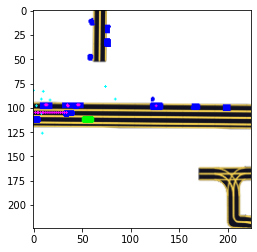

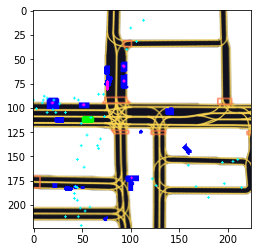

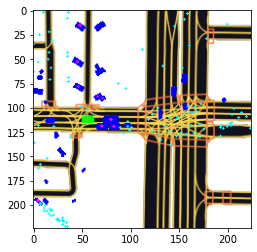

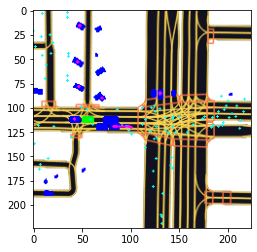

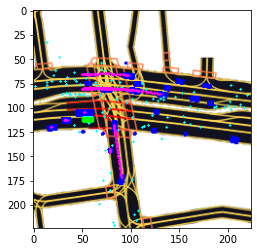

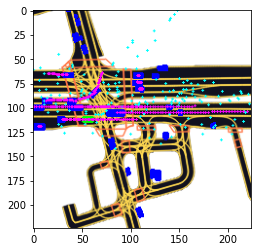

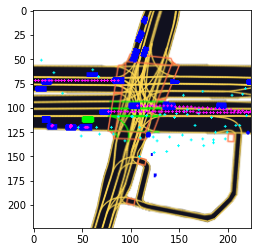

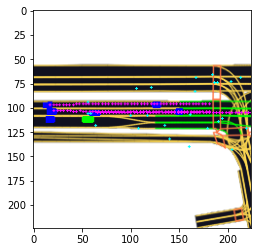

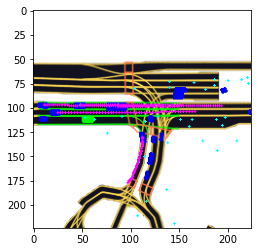

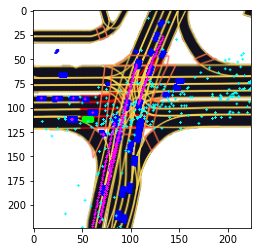

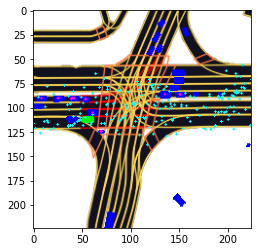

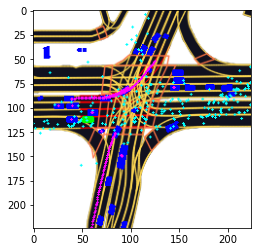

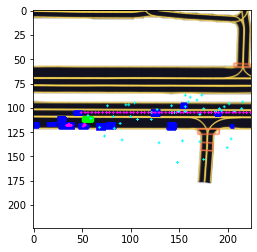

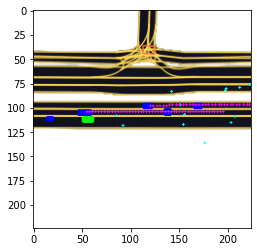

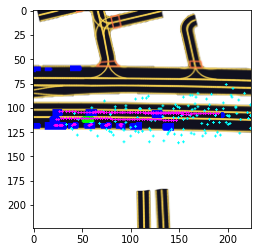

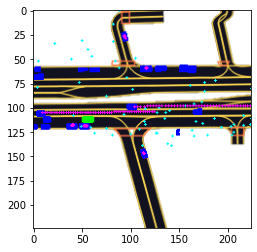

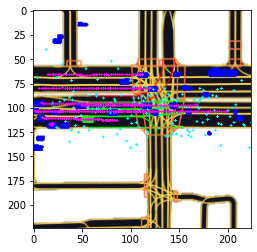

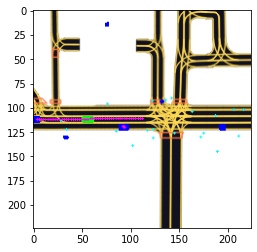

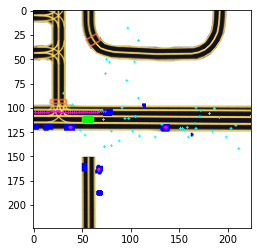

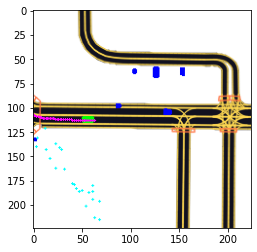

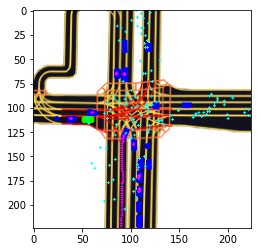

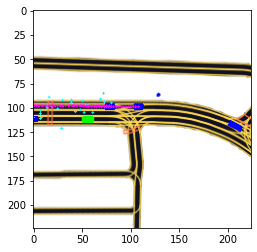

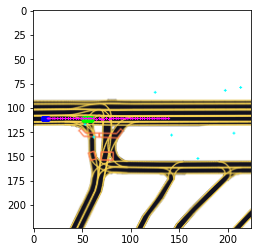

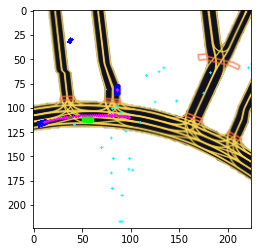

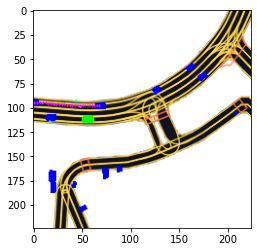

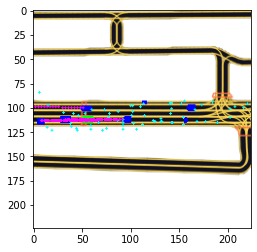

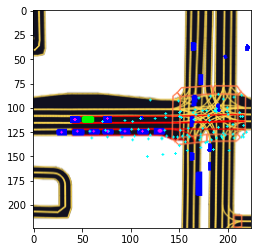

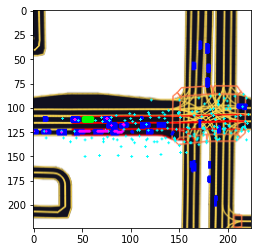

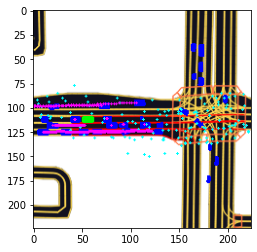

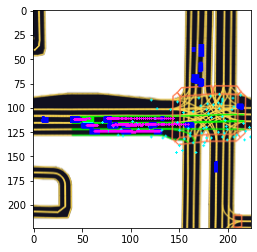

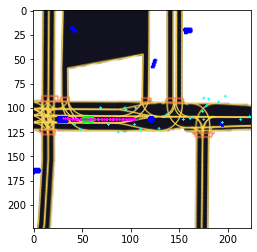

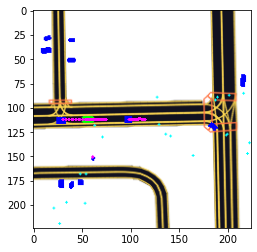

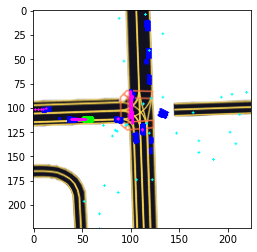

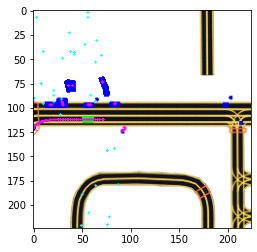

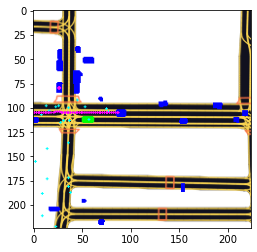

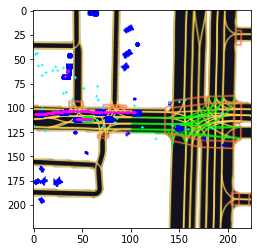

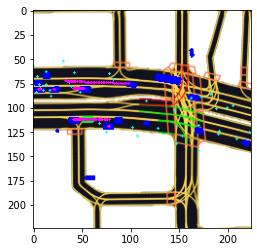

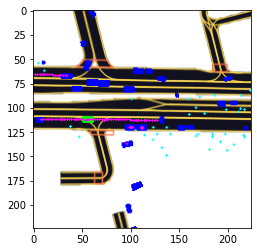

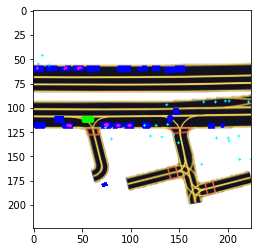

In [61]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.show()